In [193]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *
import sys
sys.path.append("../../modules/")
import helper as hp
import matplotlib.pyplot as plt
%matplotlib inline
import draw_net
from IPython.display import Image
import numpy as np

In [5]:
train_set, _, _ = hp.load_mnist("../../data/mnist.pkl.gz")

In [99]:
X_train, y_train = train_set
X_train = X_train.astype("float32")
y_train = y_train.astype("int32")

In [206]:
X_train_flipped = []
for b in range(0, X_train.shape[0]):
    X_train_flipped.append( [ np.fliplr(X_train[b][0]) ] )
X_train_flipped = np.asarray(X_train_flipped, dtype="float32")

In [210]:
l_in_left = InputLayer( (None, 1, 28, 28) )
l_in_right = InputLayer( (None, 1, 28, 28) )
# left image
l_topleft_left = SliceLayer( SliceLayer(l_in_left, indices=slice(0,14), axis=2), indices=slice(0,14), axis=3 )
l_bottomleft_left = SliceLayer( SliceLayer(l_in_left, indices=slice(14,28), axis=2), indices=slice(0,14), axis=3 )
l_topright_left = SliceLayer( SliceLayer(l_in_left, indices=slice(0,14), axis=2), indices=slice(14,28), axis=3 )
l_bottomright_left = SliceLayer( SliceLayer(l_in_left, indices=slice(14,28), axis=2), indices=slice(14,28), axis=3 )
# right image
l_topleft_right = SliceLayer( SliceLayer(l_in_right, indices=slice(0,14), axis=2), indices=slice(0,14), axis=3 )
l_bottomleft_right = SliceLayer( SliceLayer(l_in_right, indices=slice(14,28), axis=2), indices=slice(0,14), axis=3 )
l_topright_right = SliceLayer( SliceLayer(l_in_right, indices=slice(0,14), axis=2), indices=slice(14,28), axis=3 )
l_bottomright_right = SliceLayer( SliceLayer(l_in_right, indices=slice(14,28), axis=2), indices=slice(14,28), axis=3 )

In [244]:
def net_block(quadrant, dd):
    l_conv = Conv2DLayer(quadrant, num_filters=8, filter_size=3,
                         W=dd["l_conv"].W if "l_conv" in dd else GlorotUniform(),
                         b=dd["l_conv"].b if "l_conv" in dd else Constant(0.))
    l_mp1 = MaxPool2DLayer(l_conv, pool_size=2)
    l_conv2 = Conv2DLayer(l_mp1, num_filters=16, filter_size=3, 
                          W=dd["l_conv2"].W if "l_conv2" in dd else GlorotUniform(),
                          b=dd["l_conv2"].b if "l_conv2" in dd else Constant(0.))
    l_mp2 = MaxPool2DLayer(l_conv2, pool_size=2)
    l_flat = FlattenLayer(l_mp2)
    return {
        "l_conv": l_conv,
        "l_conv2": l_conv2,
        "l_flat": l_flat
    }

In [245]:
# left image
topleft_conv_left = net_block(l_topleft_left, {})
print topleft_conv_left
bottomleft_conv_left = net_block(l_bottomleft_left, topleft_conv_left)
topright_conv_left = net_block(l_topright_left, topleft_conv_left)
bottomright_conv_left = net_block(l_bottomright_left, topleft_conv_left)
# right image
topleft_conv_right = net_block(l_topleft_right, topleft_conv_left)
bottomleft_conv_right = net_block(l_bottomleft_right, topleft_conv_left)
topright_conv_right = net_block(l_topright_right, topleft_conv_left)
bottomright_conv_right = net_block(l_bottomright_right, topleft_conv_left)
print "--"
for layer in get_all_layers(topleft_conv["l_flat"]):
    print layer, layer.output_shape

{'l_flat': <lasagne.layers.shape.FlattenLayer object at 0x10d380dd0>, 'l_conv2': <lasagne.layers.conv.Conv2DLayer object at 0x117710990>, 'l_conv': <lasagne.layers.conv.Conv2DLayer object at 0x10d380e10>}
--
<lasagne.layers.input.InputLayer object at 0x1141e1050> (None, 1, 28, 28)
<lasagne.layers.shape.SliceLayer object at 0x1143f88d0> (None, 1, 14, 28)
<lasagne.layers.shape.SliceLayer object at 0x1143f8c10> (None, 1, 14, 14)
<lasagne.layers.conv.Conv2DLayer object at 0x117b89390> (None, 8, 12, 12)
<lasagne.layers.pool.MaxPool2DLayer object at 0x115b9f310> (None, 8, 6, 6)
<lasagne.layers.conv.Conv2DLayer object at 0x113742910> (None, 16, 4, 4)
<lasagne.layers.pool.MaxPool2DLayer object at 0x115c51e10> (None, 16, 2, 2)
<lasagne.layers.shape.FlattenLayer object at 0x117ba05d0> (None, 64)


In [273]:
l_concat_left = ConcatLayer([
    topleft_conv_left["l_flat"], 
    bottomleft_conv_left["l_flat"], 
    topright_conv_left["l_flat"], 
    bottomright_conv_left["l_flat"],   
])
l_concat_right = ConcatLayer([
    topleft_conv_right["l_flat"], 
    bottomleft_conv_right["l_flat"], 
    topright_conv_right["l_flat"], 
    bottomright_conv_right["l_flat"]
])

l_avg = ElemwiseSumLayer(
    [l_concat_left, l_concat_right]
)

In [274]:
l_avg.output_shape

(None, 256)

In [275]:
l_fc = DenseLayer(l_avg, num_units=10, nonlinearity=softmax)

In [266]:
count_params(l_fc)

3818

In [267]:
draw_net.draw_to_file(get_all_layers(l_fc), "graph.png")

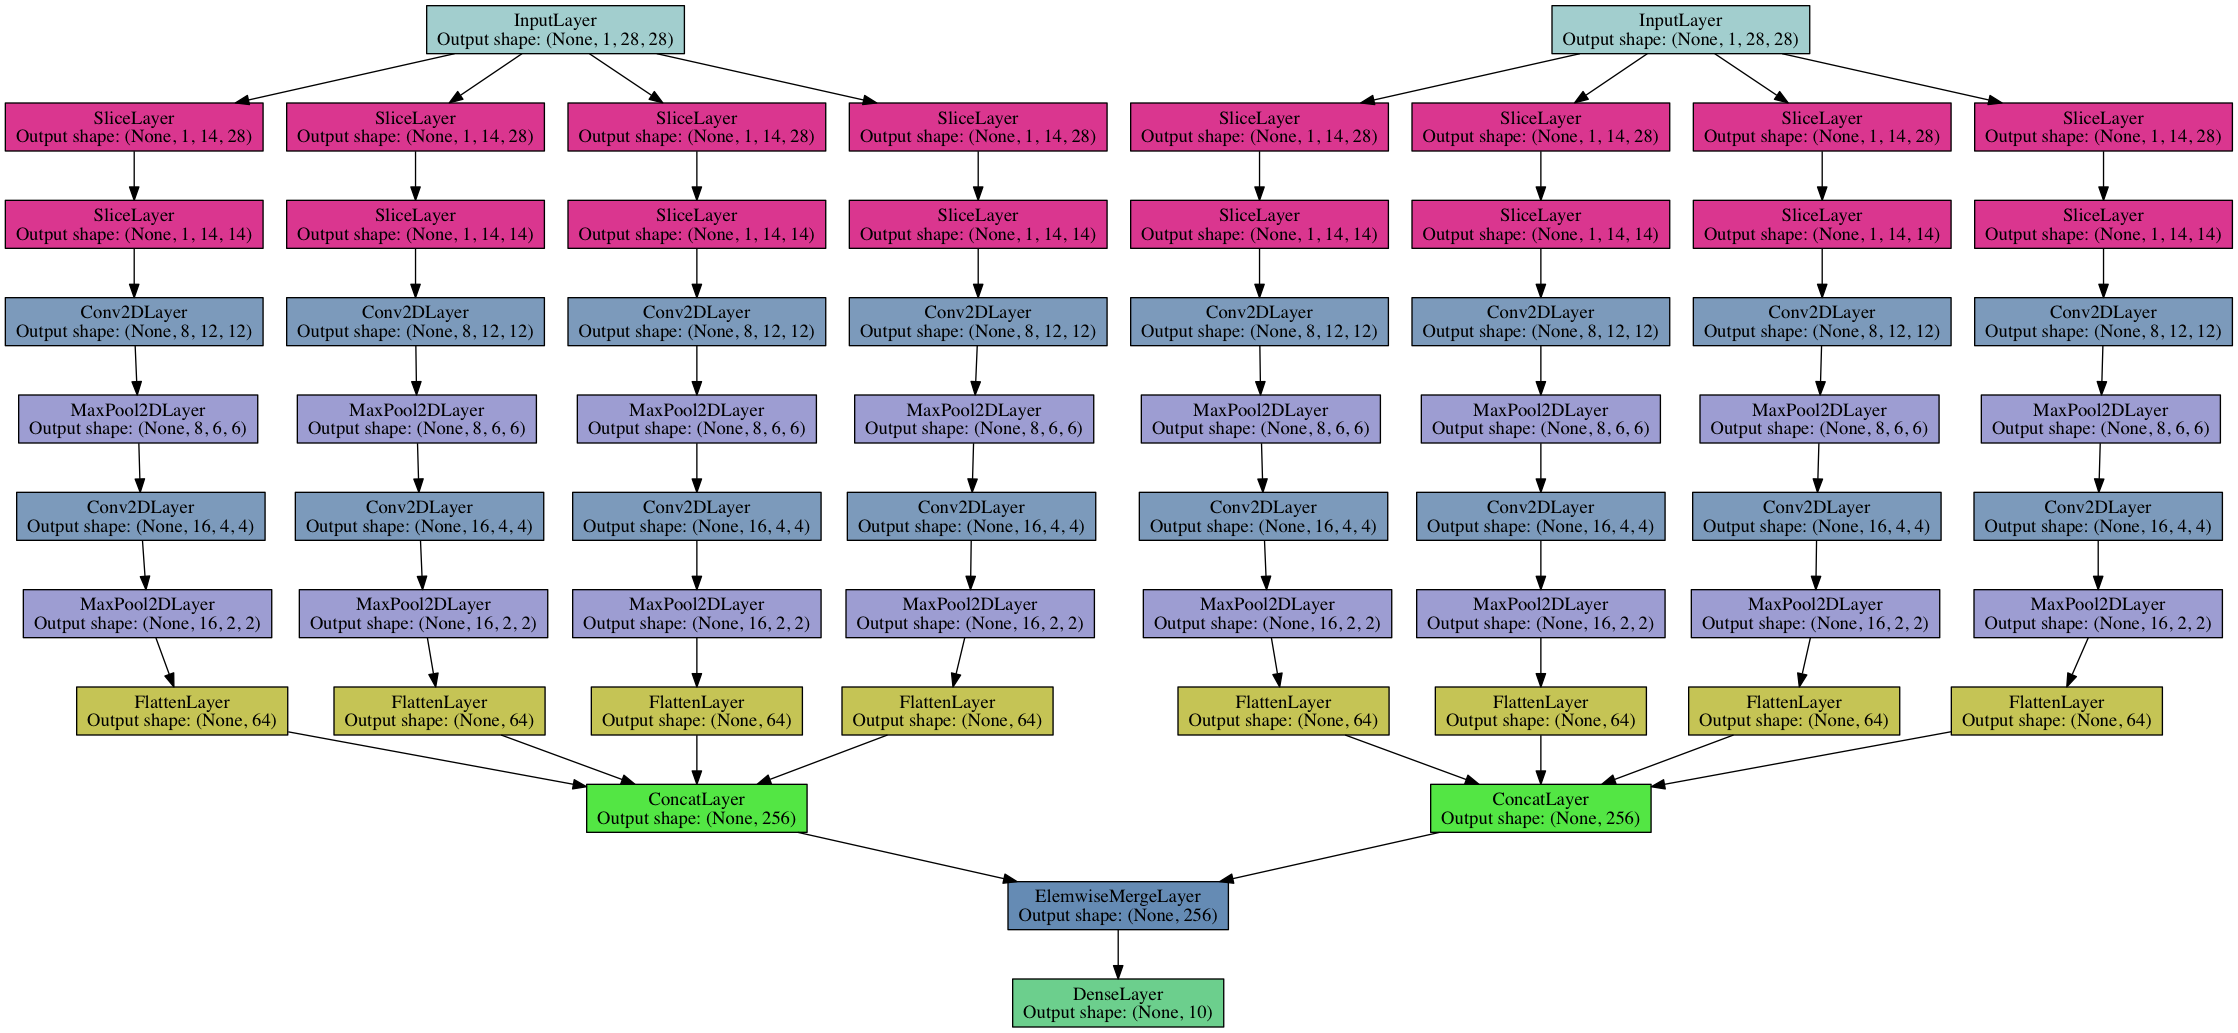

In [268]:
Image("graph.png")

-----

In [276]:
def iterate(X_left_arr, X_right_arr, y_arr, bs):
    assert X_left_arr.shape[0] == X_right_arr.shape[0] == y_arr.shape[0]
    b = 0
    while True:
        if b*bs >= X_left_arr.shape[0]:
            break
        this_X_left, this_X_right, this_y = X_left_arr[b*bs:(b+1)*bs], X_right_arr[b*bs:(b+1)*bs], y_arr[b*bs:(b+1)*bs]
        yield X_left_arr, X_right_arr, y_arr
        # ---
        b += 1

In [277]:
X_left = l_in_left.input_var
X_right = l_in_right.input_var
y = T.ivector('y')
#get_outs = [get_output(layer, X) for layer in [l_topleft, l_topright, l_bottomleft, l_bottomright]]

In [278]:
#outs_fn = theano.function([X], get_outs)

In [279]:
net_out = get_output(l_fc, {l_in_left: X_left, l_in_right: X_right})
loss = categorical_crossentropy(net_out, y).mean()
params = get_all_params(l_fc, trainable=True)
updates = nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)

In [280]:
train_fn = theano.function([X_left, X_right, y], loss, updates=updates)

In [284]:
for epoch in range(0, 10):
    train_losses = []
    for X_batch_left, X_batch_right, y_batch in iterate(X_train, X_train_flipped, y_train, bs=16):
        train_losses.append(train_fn(X_batch_left, X_batch_right, y_batch))
    print epoch+1, np.mean(train_losses)

KeyboardInterrupt: 

In [285]:
train_losses

[array(2.280644212201706), array(2.2689955887292226)]

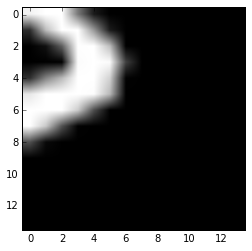

In [48]:
plt.imshow( outs_fn(X_train[0:1])[3][0][0], cmap="gray" )

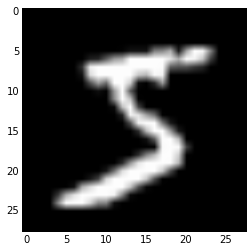

In [35]:
plt.imshow( X_train[0:1][0][0], cmap="gray" )